In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Dense, LSTM, GlobalMaxPooling1D, Concatenate
from keras.optimizers import Adam, SGD


from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 

np.random.seed(42)
tf.random.set_seed(42)

### Human Activity Recognition 
-----------------------
We will work with the Human Activity datasets collected from the sensors of the smartphones. The original dataset can be reached from the [link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Check out the kaggle [link](https://www.kaggle.com/erenaktas/human-activity-recognition) for more information about the data. 

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

--2024-05-10 22:32:13--  https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: 'UCI-HAR.zip'

UCI-HAR.zip         100%[===================>]  58.17M  15.4MB/s    in 4.1s    

2024-05-10 22:32:18 (14.1 MB/s) - 'UCI-HAR.zip' saved [60999314/60999314]



In [4]:
# unzip the zip file 

!unzip -nq UCI-HAR.zip

#### Time Series approach with RNN
--------

We will first employ the 'raw' time-series data with a suitable RNN structure. Recall that we are aiming for a classification task among $K = 6$ different human activities. By inspection of the train and test set we have the following parameters:

In [5]:
T = 128 

N_train = 7352
N_test = 2947

D = 9 # 9 files
K = 6 # number of classes

In [6]:
# helper function to load the data 


def load_data():
    
    ''' Returns X_train (N_train x T x D), y_train (N_train)
        and 
        X_test (N_test x T x D), y_test (N_test)'''
    
    # initiate train and test X 
    Xtrain = np.zeros((N_train, T, D))
    Xtest = np.zeros((N_test, T, D))
    
    train_pfx = 'UCI HAR Dataset/train/'

    # train data
    ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
    ]
    
    # get X_train
    for d, fn in enumerate(ts_filenames):

        df = pd.read_csv(f'{train_pfx}Inertial Signals/{fn}', header = None, delim_whitespace=True)

        # turn each file into a N_train x T numpy array

        x = df.to_numpy()
        #print(d, ts_fns_tr[d])

        #assing it to X_train for the corresponding d in the loop
        Xtrain[:, :, d] = x


    # train labels - 1 to render them from 0,..,5

    Ytrain = pd.read_csv(f'{train_pfx}y_train.txt', header = None).to_numpy() - 1

    Ytrain = Ytrain.flatten()

    test_pfx = 'UCI HAR Dataset/test/'

    # test data
    ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
    ]

     # get X_test
    for d, fn in enumerate(ts_filenames):


        df = pd.read_csv(f'{test_pfx}Inertial Signals/{fn}', header = None, delim_whitespace=True)

        # turn each file into a N_train x T numpy array

        x = df.to_numpy()
        #print(d, ts_fns_test[d])
        #assing it to X_train for the corresponding d in the loop
        Xtest[:, :, d] = x

    # test labels - 1

    Ytest = pd.read_csv(f'{test_pfx}y_test.txt', header = None).to_numpy() - 1

    Ytest = Ytest.flatten()

    return Xtrain, Ytrain, Xtest, Ytest     

In [7]:
X_train, y_train, X_test, y_test = load_data()

In [12]:
# RNN 

i = Input(shape = (T,D))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i,x)

In [16]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128, 32)        │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,574 (21.77 KB)

 Trainable params: 5,574 (21.77 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# check-point 

checkp = ModelCheckpoint('bestmod.keras', monitor = 'val_loss', save_best_only=True)

In [18]:
# compile and fit 

model.compile(loss = SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'])

res = model.fit(X_train, y_train, epochs = 10, callbacks = [checkp], validation_data = (X_test, y_test))

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.4649 - loss: 1.4068 - val_accuracy: 0.8202 - val_loss: 0.7358
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8439 - loss: 0.5952 - val_accuracy: 0.8439 - val_loss: 0.5461
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9037 - loss: 0.3782 - val_accuracy: 0.8843 - val_loss: 0.3553
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9264 - loss: 0.2260 - val_accuracy: 0.8795 - val_loss: 0.3208
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9365 - loss: 0.1858 - val_accuracy: 0.8914 - val_loss: 0.2988
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9397 - loss: 0.1615 - val_accuracy: 0.8816 - val_loss: 0.2910
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9444 - loss: 0.1508 - val_accuracy: 0.9033 - val_loss: 0.2588
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9487 - loss: 0.1359 - val_accu

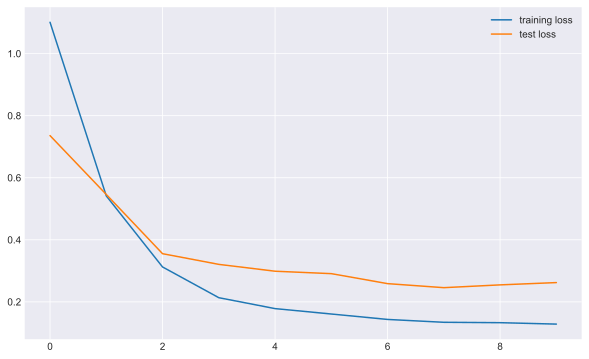

In [19]:
# loss per epoch 

fig, axes = plt.subplots(figsize = (10, 6))

axes.plot(res.history['loss'], label = 'training loss')
axes.plot(res.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

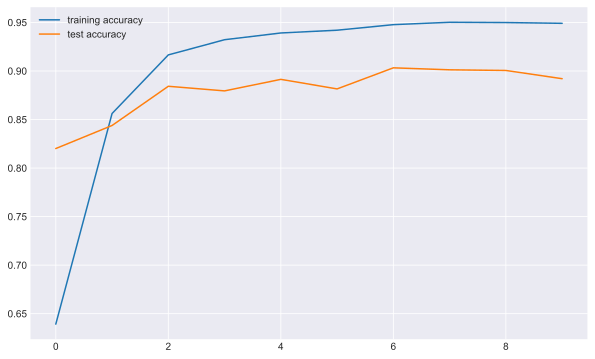

In [20]:
# accuracy per epoch 

fig, axes = plt.subplots(figsize = (10, 6))

axes.plot(res.history['accuracy'], label = 'training accuracy')
axes.plot(res.history['val_accuracy'], label = 'test accuracy')

axes.grid()
axes.legend()

In [21]:
# load best model and make precitions with it to evaluate the mean accuracy of it 

bestm = tf.keras.models.load_model('bestmod.keras')

pred_test = bestm.predict(X_test)

np.mean(np.argmax(pred_test, axis = 1) == y_test.flatten())

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


0.9012555140821175

The RNN model reaches an accuracy of 90 percent which is quite lower than some of the other models we have seen before: e.g CNN and ANN. RNN underperforms!

### Combined model that also implements the static pre-engineered features
-------

In [22]:
def load_features():

    '''Retruns X_train (N_train x D) and X_test (N_train x D)'''

    # train data 

    df = pd.read_csv('UCI HAR Dataset/train/X_train.txt', header = None, delim_whitespace=True)

    feat_train = df.to_numpy()

    # test data 

    df = pd.read_csv('UCI HAR Dataset/test/X_test.txt', header = None, delim_whitespace=True)

    feat_test = df.to_numpy()

    # scale 
    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.transform(feat_test)

    return feat_train, feat_test

In [23]:
# get training and test sets 

feat_train, feat_test = load_features()

# dimensionality of the features 

D_feat = feat_train.shape[1] 

In [25]:
# Hybrid RNN + ANN model 

# RNN 

i = Input(shape = (T, D))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)

# ANN

i2 = Input(shape = (D_feat,))
x2 = Dense(32, activation = 'relu')(i2)

# Put together the 'features' generated by CNN and ANN
x = Concatenate()([x, x2])
x = Dense(K)(x)

hmodel = Model([i,i2],x)

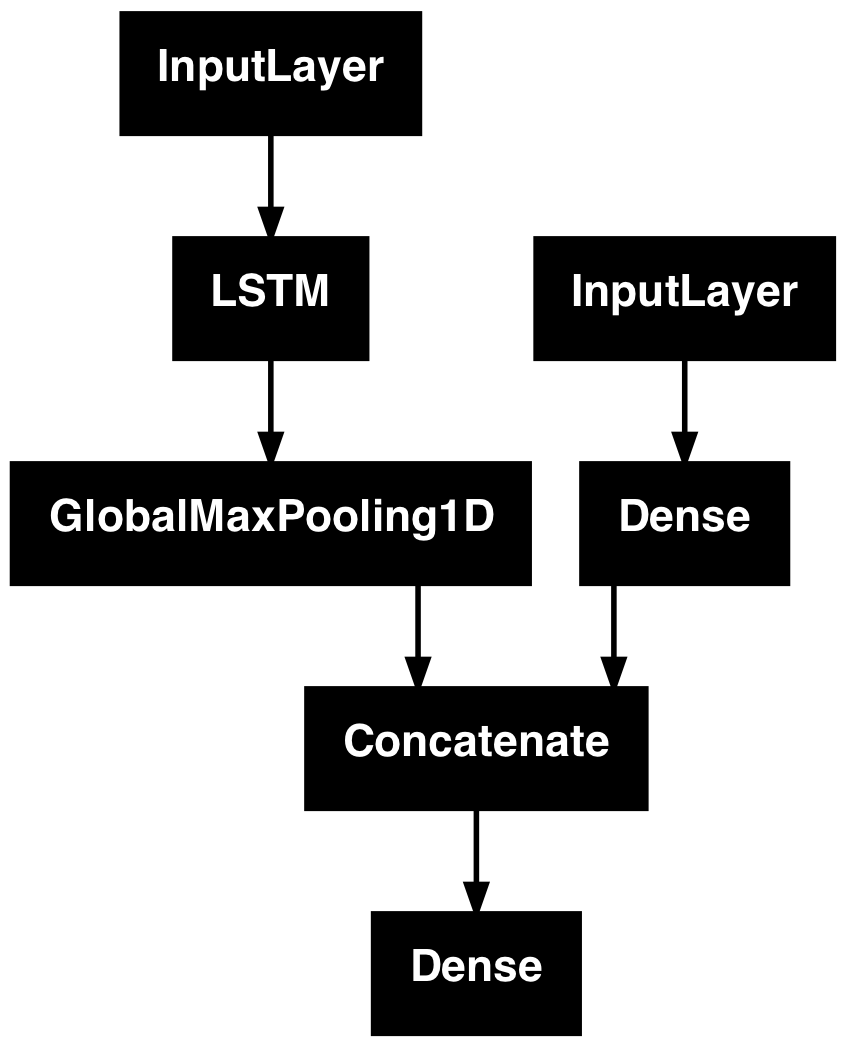

In [26]:
tf.keras.utils.plot_model(hmodel)

In [27]:
hmodel.compile(loss = SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam', metrics = ['accuracy'])

# checkpoint 

hcheck_point = ModelCheckpoint('bestmodh.keras', monitor = 'val_accuracy', save_best_only=True)

In [28]:
# fit 

hres = hmodel.fit([X_train, feat_train] , y_train, epochs = 15, callbacks = [hcheck_point], validation_data=([X_test, feat_test], y_test))

Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7774 - loss: 0.5928 - val_accuracy: 0.9298 - val_loss: 0.1962
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9643 - loss: 0.1066 - val_accuracy: 0.9308 - val_loss: 0.1708
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9754 - loss: 0.0746 - val_accuracy: 0.9430 - val_loss: 0.1448
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9805 - loss: 0.0579 - val_accuracy: 0.9433 - val_loss: 0.1417
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9822 - loss: 0.0487 - val_accuracy: 0.9450 - val_loss: 0.1467
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9828 - loss: 0.0482 - val_accuracy: 0.9477 - val_loss: 0.1373
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9862 - loss: 0.0387 - val_accuracy: 0.9508 - val_loss: 0.1391
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9886 - loss: 0.0335 - val_accu

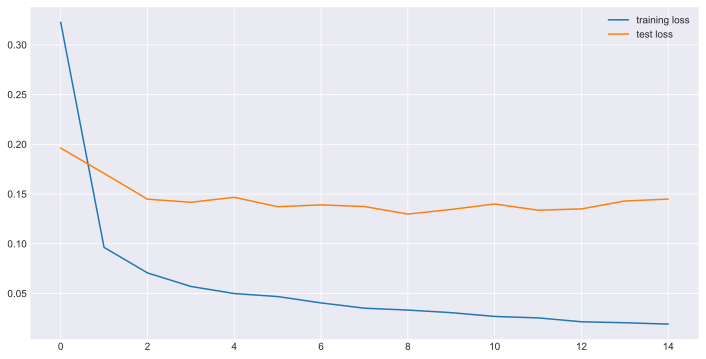

In [30]:
# plot training and test loss per epoch 

fig, axes = plt.subplots(figsize = (12,6))

axes.plot(hres.history['loss'], label = 'training loss')
axes.plot(hres.history['val_loss'], label = 'test loss')

axes.legend()

axes.grid()

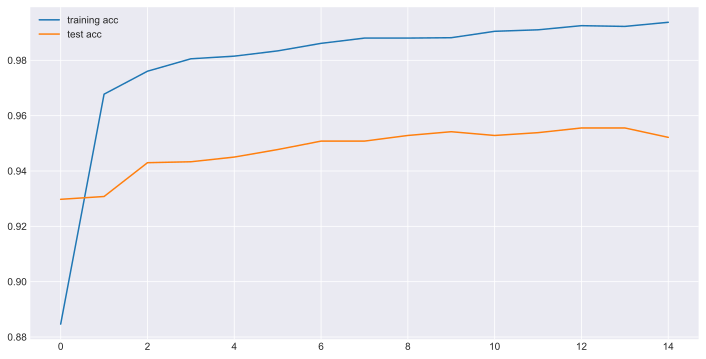

In [31]:
# plot training and test accuracy per epoch 

fig, axes = plt.subplots(figsize = (12,6))

axes.plot(hres.history['accuracy'], label = 'training acc')
axes.plot(hres.history['val_accuracy'], label = 'test acc')

axes.legend()

axes.grid()

In [32]:
# load best model, make predictions and compute the accuracy 

best_model_h = tf.keras.models.load_model('bestmodh.keras')

probs_test_h = best_model_h.predict([X_test, feat_test])

# mean accuracy of the best model which is slightly better than only time-series approach

np.mean(np.argmax(probs_test_h, axis = 1) == y_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


0.9555480149304377

Now it performs as good as other models we have seen, though still worse than simple logistic regression used with the pre-processed static features!